In [321]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from nltk.corpus import stopwords
import re
import string
import nltk
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import roc_curve, auc


mpl.rcParams['figure.figsize']=(10.0,8.0)    #(6.0,4.0)
mpl.rcParams['font.size']=10                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1


category_index = {"1":1, "-1":0}
category_reverse_index = dict((y,x) for (x,y) in category_index.items())

In [322]:
training=pd.read_csv('D:/KULIAH S2/TESIS/CNN/datapakemay.csv',engine='python')
pd.options.display.max_colwidth=2000

tags = training.Class
texts = training.Tweet
print(training.head())

                                                                                                                                          Tweet  \
0  @e100ss ini lho mas, nama jalannya Jln. Totok Kerot di maps. Sepanjang jalan daerah Majapahit berasap tebal dan bau… https://t.co/iGavpl52bF   
1                                                                  @TelkomCare @e100ss Sejak agustus akhir mati total internet sampe detik ini.   
2     @TelkomCare @e100ss perbaikan macam apa sampe 1 bulan lebih gak selesai-selesai? Tidak konfirmasi dari petugas, tidak ada yg datang sejak   
3                     @e100ss mohon info, ini kenapa ya sepanjang Jl. Totok Kerot, Majapahit Mojokerto kok berasap sangat tebal dan sangat bau?   
4       Delay dibandara juanda..shrsnya brgkt jm18.35 smpe skrng blm ada tanda2 mw diberangkatkan..@e100ss @kemenhub151 https://t.co/iELU1iDepK   

   Class  
0      0  
1      0  
2      0  
3      0  
4      0  


c:\users\laptop\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


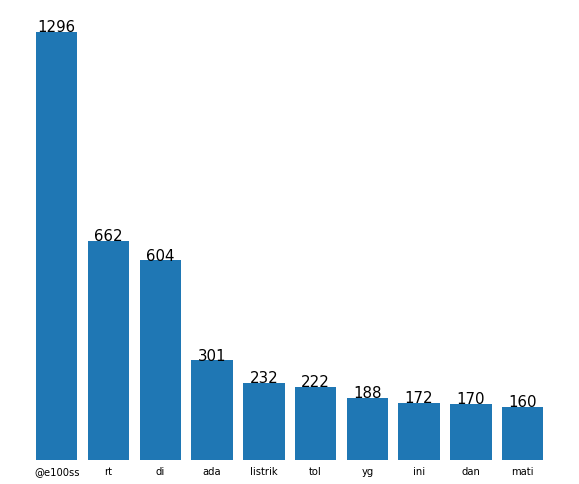

In [323]:
# Create a list of words by converting to lowercase and splitting
kata = [s.lower().split() for s in texts if s]
noline_ = [sublist for l in kata for sublist in l]
counts1 = dict(Counter(noline_).most_common(10))
labels1, values1 = zip(*counts1.items())

# sort your values in descending order
indSort1 = np.argsort(values1)[::-1]

# rearrange your data
labels1 = np.array(labels1)[indSort1]
values1 = np.array(values1)[indSort1]

indexes1 = np.arange(len(labels1))

bar_width = 1

mybar=plt.bar(indexes1, values1)
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# plt.show()

# direct label each bar with Y axis values
for bari in mybar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()-0.2, str(int(height)),
                 ha='center', color='black', fontsize=15)
# add labels
plt.xticks(indexes1, labels1)
plt.show()

In [324]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
a = vec.fit_transform(texts)
terms1 = vec.get_feature_names()
print(len(terms1))

4192


In [325]:
#preprocessing

#hapus url-link
train_nolink=[]
for line in texts:
    result=re.sub(r"http\S+","",line)
    train_nolink.append(result)

#hapur retweet
train_noRT=[]
for line in train_nolink:
    result=re.sub(r"RT","",line)
    train_noRT.append(result)
    
#remove username
train_nousername=[]
for line in train_noRT:
    result=re.sub(r"(?:\@|https?\://)\S+", "", line)
    train_nousername.append(result)

#hapus angka
from string import digits
train_nodigits=[]
for line in train_nousername:
    remove_digits=str.maketrans(' ', ' ', digits)
    result=line.translate(remove_digits)
    train_nodigits.append(result)
    
#replace , menjadi whitespace
training_nocomma=[]
for line in train_nodigits :
    result=re.sub(r"[,./]+", " ", line)
    training_nocomma.append(result)
    
#remove punctuations
train_nopunc=[]
for line in training_nocomma:
    punc = set(string.punctuation)
    result = ''.join(x for x in line if x not in punc)
    train_nopunc.append(result)

#case folding
train_lower=[]
for line in train_nopunc:
    a=line.lower()
    train_lower.append(a)

#import stopword
stop=open('D:\KULIAH S2\TESIS\CNN\stopword zakya.csv', 'r',encoding='utf8')
stopword = []
# Convert lines into string list.
for line in stop.readlines():
    stopword.append(line.rstrip())
    
from nltk.tokenize import word_tokenize
#hapus stopword
trainfinal = []
for line in train_lower: 
    word_token = nltk.word_tokenize(line) # get word token for every line (split line into each separate words)
    word_token = [word for word in word_token if not word in stopword] # remove indonesian stop words
    trainfinal.append(" ".join(word_token))
#tokenizing
from nltk.tokenize import word_tokenize
token_keluhan=[]
for line in trainfinal:
    b = nltk.word_tokenize(line)
    token_keluhan.append(b)

c:\users\laptop\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


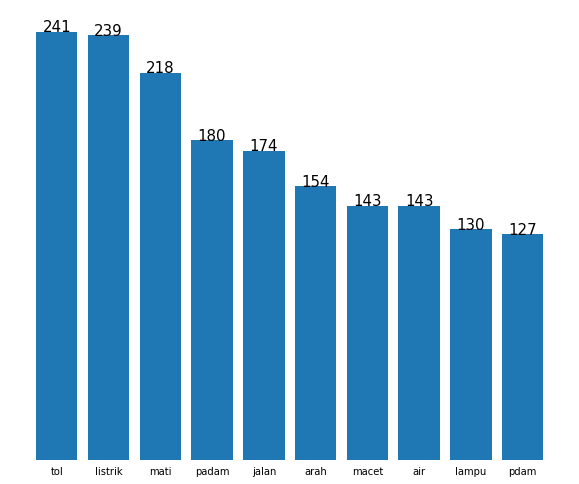

In [326]:
#hitung 10 term terbanyak setelah preprocessing
token = [sublist for l in token_keluhan for sublist in l]
counts = dict(Counter(token).most_common(10))
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 1

mybar=plt.bar(indexes, values)
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# plt.show()

# direct label each bar with Y axis values
for bari in mybar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()-0.2, str(int(height)),
                 ha='center', color='black', fontsize=15)
# add labels
plt.xticks(indexes, labels)
plt.show()

In [327]:
#hitung jumlah terms setelah preprocessing
vec_2 = CountVectorizer()
a2 = vec.fit_transform(trainfinal)
terms2 = vec.get_feature_names()
print(len(terms2))

2976


In [328]:
#membuat DTM
vec = CountVectorizer()
X = vec.fit_transform(trainfinal)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df

,abis,ac,acara,action,ad,ada,adakan,adat,adeeemmmm,adha,...,yatoma,yg,yl,ylaporan,ylkiid,yo,yonosuwoyodepan,zebra,zone,zuwuuun
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [329]:
#membuat data frame anggota klaster 
train_final_df=pd.DataFrame(trainfinal)
train_final_df.columns=['tweet']
train_final_df['class']=pd.Series(tags, index=training.index)
train_final_df

,tweet,class
0,lho mas nama jalannya totok kerot maps jalan daerah majapahit berasap tebal bau…,0
1,agustus mati total internet detik,0
2,perbaikan selesaiselesai konfirmasi petugas,0
3,mohon info jl totok kerot majapahit mojokerto berasap tebal bau,0
4,delay dibandara juanda shrsnya brgkt jm smpe skrng tanda mw diberangkatkan,0
5,alhamdulillah listrik menyala terima,1
6,kegiatan dilangsungkan oktober desember kegiatan hasil kerjasama pemkot…,1
7,travo meledak blok b ditangani pln,0
8,kawasan kembang kuning mati lampu info,0
9,sosialisasi etoll paksa pakai etoll kartu brizzi pakai,0


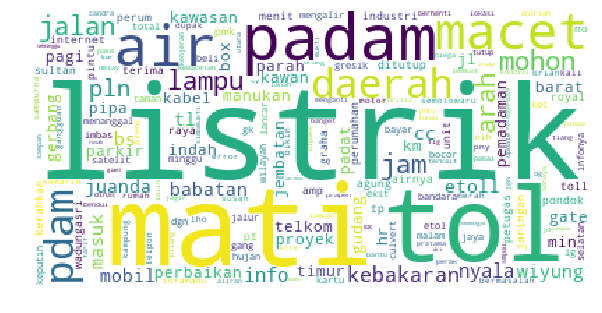

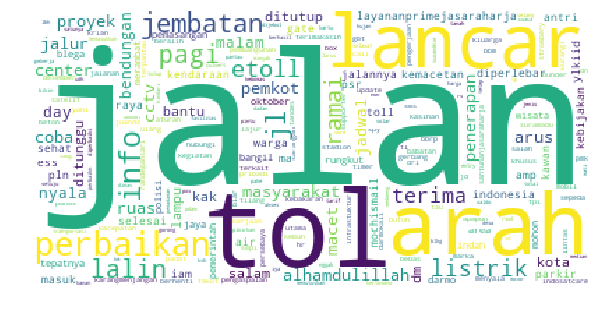

In [330]:
num_class=2
a = {}
b = {}
klaster = {}
i = -1
c = {}
for j in range(num_class):
    i += 1
    a[i] = train_final_df.loc[train_final_df['class'] == i,'tweet']
    b[i] =' '.join(a[i])
    klaster["class" + str(i)]  = b[i]
    c[i]= WordCloud(collocations = False,background_color='white',stopwords=stopword,max_words=2000,max_font_size=200,random_state=30).generate(b[i])
    fig = plt.figure(1)
    plt.imshow(c[i])
    plt.axis('off')
    plt.show()

In [331]:
df.to_csv('dtm.csv', sep='\t', encoding='utf-8')

In [337]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
tf_vectorizer = CountVectorizer(min_df=1)
tf = tf_vectorizer.fit_transform(trainfinal)
tf

<1500x2976 sparse matrix of type '<class 'numpy.int64'>'
	with 13130 stored elements in Compressed Sparse Row format>

In [338]:
for i, feature in enumerate(tf_vectorizer.get_feature_names()):
    print(i, feature)
    

0 abis
1 ac
2 acara
3 action
4 ad
5 ada
6 adakan
7 adat
8 adeeemmmm
9 adha
10 adil
11 adl
12 adlh
13 admin
14 agar
15 agen
16 agt
17 agung
18 agustus
19 ahmad
20 aini
21 air
22 aireduaubdedubuaaeduaubdedubuaa
23 airnya
24 ajaib
25 ajang
26 ajur
27 akbar
28 akhirn
29 akibat
30 akp
31 akses
32 aksi
33 aktif
34 al
35 ala
36 alam
37 alamat
38 alangkah
39 alasan
40 alat
41 alatbpembayaran
42 alfa
43 alfamart
44 alhamdulillah
45 aliran
46 allah
47 allhamdulilah
48 aloha
49 alohawaru
50 alternatif
51 aman
52 amble
53 ambles
54 amblesnya
55 ambrol
56 amit
57 amp
58 ampel
59 ampun
60 an
61 anak
62 and
63 andai
64 andong
65 ane
66 aneh
67 anggaswangi
68 angka
69 angkat
70 angkot
71 anom
72 anomali
73 answer
74 antisipasi
75 antre
76 antrean
77 antri
78 antrian
79 antriannya
80 ap
81 apapun
82 apartment
83 api
84 apkh
85 applause
86 arah
87 area
88 argo
89 arjuno
90 arteri
91 arti
92 arua
93 arus
94 arusnya
95 asa
96 asalan
97 asap
98 asapnya
99 asas
100 asem
101 asemrowo
102 asih
103 aspal
104 a

1120 kartunya
1121 karung
1122 karya
1123 kasi
1124 kasian
1125 kasih
1126 kasihan
1127 kasur
1128 katamso
1129 katax
1130 kauman
1131 kawan
1132 kawasan
1133 kaya
1134 kayak
1135 kayaknya
1136 kbs
1137 kcil
1138 kcl
1139 kd
1140 kdg
1141 ke
1142 keama
1143 keamanan
1144 kebacuut
1145 kebakaran
1146 kebanyakan
1147 keberatan
1148 kebiasaan
1149 kebijakan
1150 keboan
1151 kebocoran
1152 kebomas
1153 kebonsari
1154 kebrsihan
1155 kebun
1156 kebutuhan
1157 kec
1158 kecelakaan
1159 kecele
1160 kecepatan
1161 kecewa
1162 keciil
1163 kecilamp
1164 kecoklat
1165 kecoklatan
1166 kecuali
1167 kedam
1168 kedamean
1169 kedameanlegundi
1170 kedipkedip
1171 kedung
1172 kedungdoro
1173 kedungsari
1174 kedurus
1175 keep
1176 kegiatan
1177 kehabisan
1178 keindahan
1179 kejahatan
1180 kejapanan
1181 kejawan
1182 kejelasan
1183 kejutan
1184 kekurangan
1185 kel
1186 kelemahan
1187 kelemahannya
1188 kelihatanny
1189 kelip
1190 keluarnya
1191 keluhkan
1192 kemacetan
1193 kemahalan
1194 kemampuan
1195 kemar

1870 palm
1871 pam
1872 panas
1873 panaspanas
1874 pancasila
1875 pandang
1876 pandugo
1877 panggang
1878 panggung
1879 panjaaaang
1880 panjangjiwo
1881 panjangnya
1882 pantau
1883 pantauan
1884 pantura
1885 parah
1886 pariwara
1887 park
1888 parkir
1889 pas
1890 pasang
1891 pasar
1892 pasien
1893 pasir
1894 pasirian
1895 pasrah
1896 pasuran
1897 pasurua
1898 patmosusastro
1899 pavedment
1900 payah
1901 payahbagaimana
1902 pd
1903 pdak
1904 pdam
1905 pdamnya
1906 pdhal
1907 pdhl
1908 pe
1909 pecah
1910 pecerahan
1911 pecinta
1912 pedestrian
1913 pegawai
1914 pejalan
1915 pejalanan
1916 peka
1917 pekan
1918 pekat
1919 pekerja
1920 pekerjaan
1921 pelabuhan
1922 pelalulintas
1923 pelan
1924 pelanggan
1925 pelanggaran
1926 pelaporan
1927 pelaporannya
1928 pelay
1929 pelayanan
1930 pelayananmu
1931 pelebaran
1932 pelebarannya
1933 pemadam
1934 pemadaman
1935 pemadamannya
1936 pemagku
1937 pemakai
1938 pemandangan
1939 pemasangan
1940 pembagian
1941 pembangunan
1942 pembasmi
1943 pembatas
19

2869 ulang
2870 umbulan
2871 umu
2872 umumsatu
2873 umur
2874 undaan
2875 unesa
2876 unit
2877 untk
2878 untung
2879 untunglah
2880 upaya
2881 upayakan
2882 update
2883 updatenya
2884 upn
2885 uranggantung
2886 urgent
2887 urip
2888 uripsumoharjo
2889 usee
2890 ush
2891 utama
2892 utara
2893 utk
2894 veteran
2895 viiie
2896 villa
2897 voltase
2898 volume
2899 vs
2900 wa
2901 wadah
2902 wadung
2903 wadungasri
2904 wage
2905 wahyudi
2906 wajar
2907 wajib
2908 wakt
2909 walikota
2910 walimurid
2911 walo
2912 warga
2913 warna
2914 warnanya
2915 warni
2916 warugunung
2917 warujuanda
2918 waspada
2919 wawasanssfm
2920 wedi
2921 wes
2922 western
2923 weta
2924 wetan
2925 wewenangnya
2926 wez
2927 why
2928 wib
2929 wifi
2930 wiguna
2931 wil
2932 wilayah
2933 wilayahwilayah
2934 wildman
2935 wisata
2936 wisma
2937 wiyng
2938 wiyung
2939 wiyungmenga
2940 wiyungmenganti
2941 wnokromo
2942 wonoayu
2943 wonocolo
2944 wonokromo
2945 wonokusumo
2946 wonolangan
2947 wonorejo
2948 wonorejomanukan
2949 

In [314]:
#Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

#Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsity = Percentage of Non-Zero cells
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsity:  0.2940320232896652 %


In [339]:
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = tf.shape[1]
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(trainfinal)

trainfinal_sequences = tokenizer.texts_to_sequences(trainfinal)

trainfinal_data = pad_sequences(trainfinal_sequences, maxlen=MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index

In [340]:
print("train final shape: ", trainfinal_data.shape)

data = np.vstack((trainfinal_data))
category = pd.concat([training['Class']]).values
category = to_categorical(category)
print("-"*10)
print("combined data shape: ", data.shape)
print("combined category/label shape: ", category.shape)

train final shape:  (1500, 2976)
----------
combined data shape:  (1500, 2976)
combined category/label shape:  (1500, 2)


In [341]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
token_keluhan=[]
for line in trainfinal:
    b = nltk.word_tokenize(line)
    token_keluhan.append(b)

model = Word2Vec(token_keluhan, min_count=1, alpha=0.025, size=100)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['jalan'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)
w=model[model.wv.vocab]
print(w)

c:\users\laptop\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Word2Vec(vocab=3061, size=100, alpha=0.025)
['lho', 'mas', 'nama', 'jalannya', 'totok', 'kerot', 'maps', 'jalan', 'daerah', 'majapahit', 'berasap', 'tebal', 'bau…', 'agustus', 'mati', 'total', 'internet', 'detik', 'perbaikan', 'selesaiselesai', 'konfirmasi', 'petugas', 'mohon', 'info', 'jl', 'mojokerto', 'bau', 'delay', 'dibandara', 'juanda', 'shrsnya', 'brgkt', 'jm', 'smpe', 'skrng', 'tanda', 'mw', 'diberangkatkan', 'alhamdulillah', 'listrik', 'menyala', 'terima', 'kegiatan', 'dilangsungkan', 'oktober', 'desember', 'hasil', 'kerjasama', 'pemkot…', 'travo', 'meledak', 'blok', 'b', 'ditangani', 'pln', 'kawasan', 'kembang', 'kuning', 'lampu', 'sosialisasi', 'etoll', 'paksa', 'pakai', 'kartu', 'brizzi', 'bayar', 'tol', 'cash', 'dibilang', 'kartunya', 'digempol', 'kereta', 'api', 'penataran', 'dhoho', 'jurusan', 't', 'agung', 'jam', 'gerbong', 'ac', 'sumuk', 'duech', 'selamat', 'kesaktian', 'pancasila', 'syg', 'babatan', 'indah', 'off', 'sakti', 'blas', 'perum', 'griya', 'mukti', 'yach', '

Word2Vec(vocab=3061, size=100, alpha=0.025)
[[ 2.3058248e-03  2.1099907e-03 -1.9973842e-03 ...  2.3471641e-03
   4.2829709e-03 -3.8741953e-03]
 [ 9.1219647e-03 -3.2519579e-03 -1.1342294e-03 ... -7.3089212e-04
   4.3713995e-03 -1.5358415e-03]
 [ 4.5097177e-03  4.2866106e-04  8.7739807e-04 ... -5.1338784e-06
   1.5801062e-03  2.0473809e-03]
 ...
 [ 4.0902132e-03 -4.7461111e-03  1.0783348e-03 ... -7.1326713e-04
  -1.1205503e-03  1.9541329e-03]
 [ 1.2578811e-03 -7.1576168e-04 -2.3417987e-03 ... -4.5295290e-04
  -7.2440220e-04  9.7040716e-04]
 [-3.2407821e-03 -8.0505922e-04  3.4270980e-03 ...  3.1255959e-03
  -2.2496218e-03 -7.6549948e-04]]


c:\users\laptop\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [342]:
from keras.layers import Embedding
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.wv.vocab:
        embedding_matrix[i] = word2vec.wv[word]
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Null word embeddings: 1


In [344]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)

cvscores = []
for train, test in kfold.split(data,tags):
    category_train = to_categorical(tags[train])
    category_test = to_categorical(tags[test])
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Conv1D(300,3, padding='valid',activation='relu',strides=2))
    model.add(Conv1D(150,3, padding='valid',activation='relu',strides=2))
    model.add(Conv1D(75,3, padding='valid',activation='relu',strides=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(150,activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
    model.fit(data[train], category_train, epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(data[test], category_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
model.summary()
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 87.42%
acc: 89.33%


KeyboardInterrupt: 

KeyboardInterrupt: 